In [31]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [127]:
# %load plot_clustered_ts.py
def plot_clustered_ts(timeSeries, k,method, metric, anim, plot = True):
    %matplotlib inline
    from scipy.cluster.hierarchy import fcluster, linkage
    import math
    import time

    Z = linkage(timeSeries,  method=method, metric=metric)
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    #print(results)
    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    if anim == True:
        %matplotlib

    fig = plt.figure(1, figsize = (15,10))
    for i, c in enumerate(clusters):

        cluster_indeces = s[s==c].index

        if plot:
            with plt.style.context(('bmh')):
                x = math.ceil(k/2)
                ax = fig.add_subplot(x,2,i+1)
                if anim == True:
                    axes = fig.add_subplot(x,2,i+1)

                    for cluster_index in range(len(cluster_indeces)):
                        axes = plt.gca()
                        
                        axes.set_ylim(-3, +3)
                        plt.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])
                        plt.draw()
                        plt.pause(0.1)
                        plt.set_title("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
                        #plt.legend(frameon=False, loc='lower right', ncol=2)

                else:
                    for cluster_index in range(len(cluster_indeces)):
                        ax.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])
                        plt.title("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
                        plt.legend(frameon=False, loc='lower right', ncol=2)
                    plt.close()
        else:
            print("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
    plt.close(1)
    return results

def plot_clustered_ts_part(timeSeries, k,method, metric,n, anim, plot = True):
    %matplotlib inline
    from scipy.cluster.hierarchy import fcluster
    import math
    import time

    Z = linkage(timeSeries.T[:n].T,  method=method, metric=metric)
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    #print(results)
    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    if anim == True:
        %matplotlib inline

    fig = plt.figure(1, figsize = (15,10))
    for i, c in enumerate(clusters):

        cluster_indeces = s[s==c].index

        if plot:
            with plt.style.context(('bmh')):
                x = math.ceil(k/2)
                ax = fig.add_subplot(x,2,i+1)
                if anim == True:
                    axes = fig.add_subplot(x,2,i+1)

                    for cluster_index in range(len(cluster_indeces)):
                        axes = plt.gca()
                        axes.set_ylim(-3, +3)

                        plt.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])
                        plt.draw()
                        plt.pause(0.1)
                        #plt.set_title("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
                        #plt.legend(frameon=False, loc='lower right', ncol=2)

                else:
                    for cluster_index in range(len(cluster_indeces)):
                        ax.plot(timeSeries.T.iloc[:,cluster_indeces[cluster_index]], marker = ".",label = cluster_indeces[cluster_index])
                        plt.title("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
                        plt.legend(frameon=False, loc='lower right', ncol=2)

        else:
            print("Cluster %d - number of entries %d" % (c, len(cluster_indeces)))
    plt.close(1)
    return results

In [128]:
# %load plot_heatmap.py
def plot_heatmap(timeSeries, best_method, best_metric):
    mask = timeSeries.isnull().T
    with sns.axes_style("white"):
        ax = sns.clustermap(timeSeries.T.fillna(0), metric=best_metric,method=best_method, col_cluster = False,figsize=(17,15),mask = mask)
        plt.show()


## advanced heatmap with annotation

def print_heatmap2(timeSeries, user_cycle_df, cycle_length, metric, method, first_cycle = True):

    import seaborn as sns; sns.set(color_codes=True)

    if cycle_length == "all":
        users = user_cycle_df[["user","cycle_index","cycle_number"]]
        users = users.set_index(users.cycle_index)
        figsize = (15,30)

    else:
        users = user_cycle_df[user_cycle_df.cycle_length == cycle_length][["user","cycle_index","cycle_number"]]
        users = users.set_index(users.cycle_index)
        figsize = (15,15)

    timeSeries = timeSeries.T.reset_index().set_index("cycle_index").drop("level_0", axis = 1)



    max_cycle_numbers = len(users.cycle_number.unique())-3
    colors = "rrr"+("w"*max_cycle_numbers)

    lut = dict(zip(users.user.unique(), sns.hls_palette(len(set(users.user)),l=0.4)))
    row_colors = users.user.map(lut).rename("user")

    lut2 = dict(zip(users.cycle_number.unique(), colors))
    row_colors2 = users.cycle_number.map(lut2).rename("first cycle")

    row_color = [row_colors2, row_colors]
    if first_cycle == False:
        row_color = row_colors

    mask = timeSeries.isnull()
    with sns.axes_style("white"):
        ax = sns.clustermap(timeSeries.fillna(0),
                    metric=metric,method=method,
                    col_cluster = False,
                    figsize=figsize,
                    row_colors = row_color,
                    mask = mask,
                    )
        plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
        plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=90) # For x axis
        plt.title('', fontsize=12)
        plt.suptitle(method+"-"+metric+" clustered cylces ("+str(cycle_length)+" Days)", fontsize=20)
        plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [129]:
# %load plot_dendro.py
# Do the clustering
def plot_dendro(timeSeries, method, metric, k, feature, cycle_length):
    Z = linkage(timeSeries,  method=method, metric=metric)
    with plt.style.context(('bmh')):
    # Plot dendogram
        set_link_color_palette(['m', 'c', 'y', 'k'])
        d = plt.figure(figsize=(15, 7))
        plt.title(str(feature+" "+str(cycle_length)+" Days "+str(method)+" "+str(metric)+" "+str(k)))
        plt.xlabel('cycle index')
        plt.ylabel('distance')
        dendrogram(Z,
            leaf_rotation=90., # rotates the x axis labels\
            leaf_font_size=8., # font size for the x axis labels\
            show_contracted=True)
    return d, Z


In [130]:
# %load cycle_transform.py
def cycle_transform(df, value, save = True):

    value_ = df[["cycle_day", value, "cycle_index"]]

    value_zero = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_).fillna(0)
    value_nan = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_)

    if save == True:
        value_zero.to_csv("Data/"+value+"_zero.csv")
        value_nan.to_csv("Data/"+value+"_nan.csv")
    return value_zero, value_nan

In [131]:
def cluster_order(clusters, ts):
    cluster = {"cluster" : clusters, "cycle_index":ts.T.columns}
    cluster = pd.DataFrame(cluster)
    cluster = cluster.sort_values(by="cluster")

    return cluster

In [110]:
def heatmap_ordered(clustered_df, timeSeries):
    %matplotlib inline
    cols = list(clustered_df["cycle_index"])

    col_name = timeSeries.columns[0][0]

    new = timeSeries[col_name][cols]

    cluster_cycleindex = clustered_df.set_index("cycle_index")

    fig = plt.figure(figsize=(15,30))  
    
    lut = dict(zip(cluster_cycleindex.cluster.unique(), sns.hls_palette(len(set(cluster_cycleindex.cluster)),l=0.4)))
    row_colors = cluster_cycleindex.cluster.map(lut).rename("cluster")
    with sns.axes_style("white"):
        ax = sns.clustermap(new.T, row_colors = row_colors,row_cluster=True, col_cluster=False, figsize = (15,24), robust = True)
        plt.setp(ax.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
        plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

## Data

In [76]:
#br29_norm = pd.read_csv("Data/br_29_norm.csv")
#hr29_norm = pd.read_csv("Data/hr_29_norm.csv")
#st29_norm = pd.read_csv("Data/st_29_norm.csv")

df_regLen = pd.read_csv("Data/regLen.csv").drop(["Unnamed: 0", "index"], axis = 1)

groupby_cycles = df_regLen.groupby(["cycle_index","user","cycle_number"]).mean()
user_cycle_df = pd.DataFrame(groupby_cycles.reset_index()[["cycle_index", "user", "cycle_number", "cycle_length"]])
user_cycle_df["cycle_length"] = user_cycle_df["cycle_length"].astype(int)

#missing days interpolated
md = pd.read_csv("Data/missingdays_interpolated.csv")
#complete cycles
cc = pd.read_csv("Data/data_clean2.csv")

#example
hr29_norm_zero, hr29_norm_nan = cycle_transform(md[md.cycle_length == 29], "hr_norm", True)
hr29_norm_zero2, hr29_norm_nan2 = cycle_transform(cc[cc.cycle_length == 29], "hr_norm", True)


hr_zero, hr_nan = cycle_transform(md[md.cycle_length == 29], "hr", True)
hr_zero2, hr_nan2 = cycle_transform(cc[cc.cycle_length == 29], "hr", True)

hr29_norm_nan_md_cc = pd.concat([hr29_norm_nan, hr29_norm_nan2], axis=1, join_axes=[hr29_norm_nan.index])
hr29_nan_md_cc = pd.concat([hr_zero, hr_zero2], axis=1, join_axes=[hr29_norm_nan.index])

# bray curtis & complete

In [87]:
feature = "Heart Rate (z-score)"
%matplotlib inline
cycle_length = "29"
timeSeries = hr29_norm_nan_md_cc.fillna(0)
ts = timeSeries.T.reset_index().drop("level_0", axis =1).set_index("cycle_index")
k = 6
method = "ward"
metric = "euclidean"
#plot_dendro(timeSeries, method, metric, k, feature, cycle_length)
clusters = plot_clustered_ts(ts, k, method, metric, anim=True, plot = True)
plt.savefig('foo_.png', bbox_inches='tight')
print(clusters)


Using matplotlib backend: MacOSX


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[5 6 6 5 6 5 4 4 6 1 5 6 4 6 4 4 4 6 5 6 1 2 4 2 6 2 4 6 5 6 1 2 6 4 4 6 2
 1 4 5 3 6 4 6 5 6 2 6 6 5 6 6 6 6 4 6 5 2 3 5 3 1 5 6]


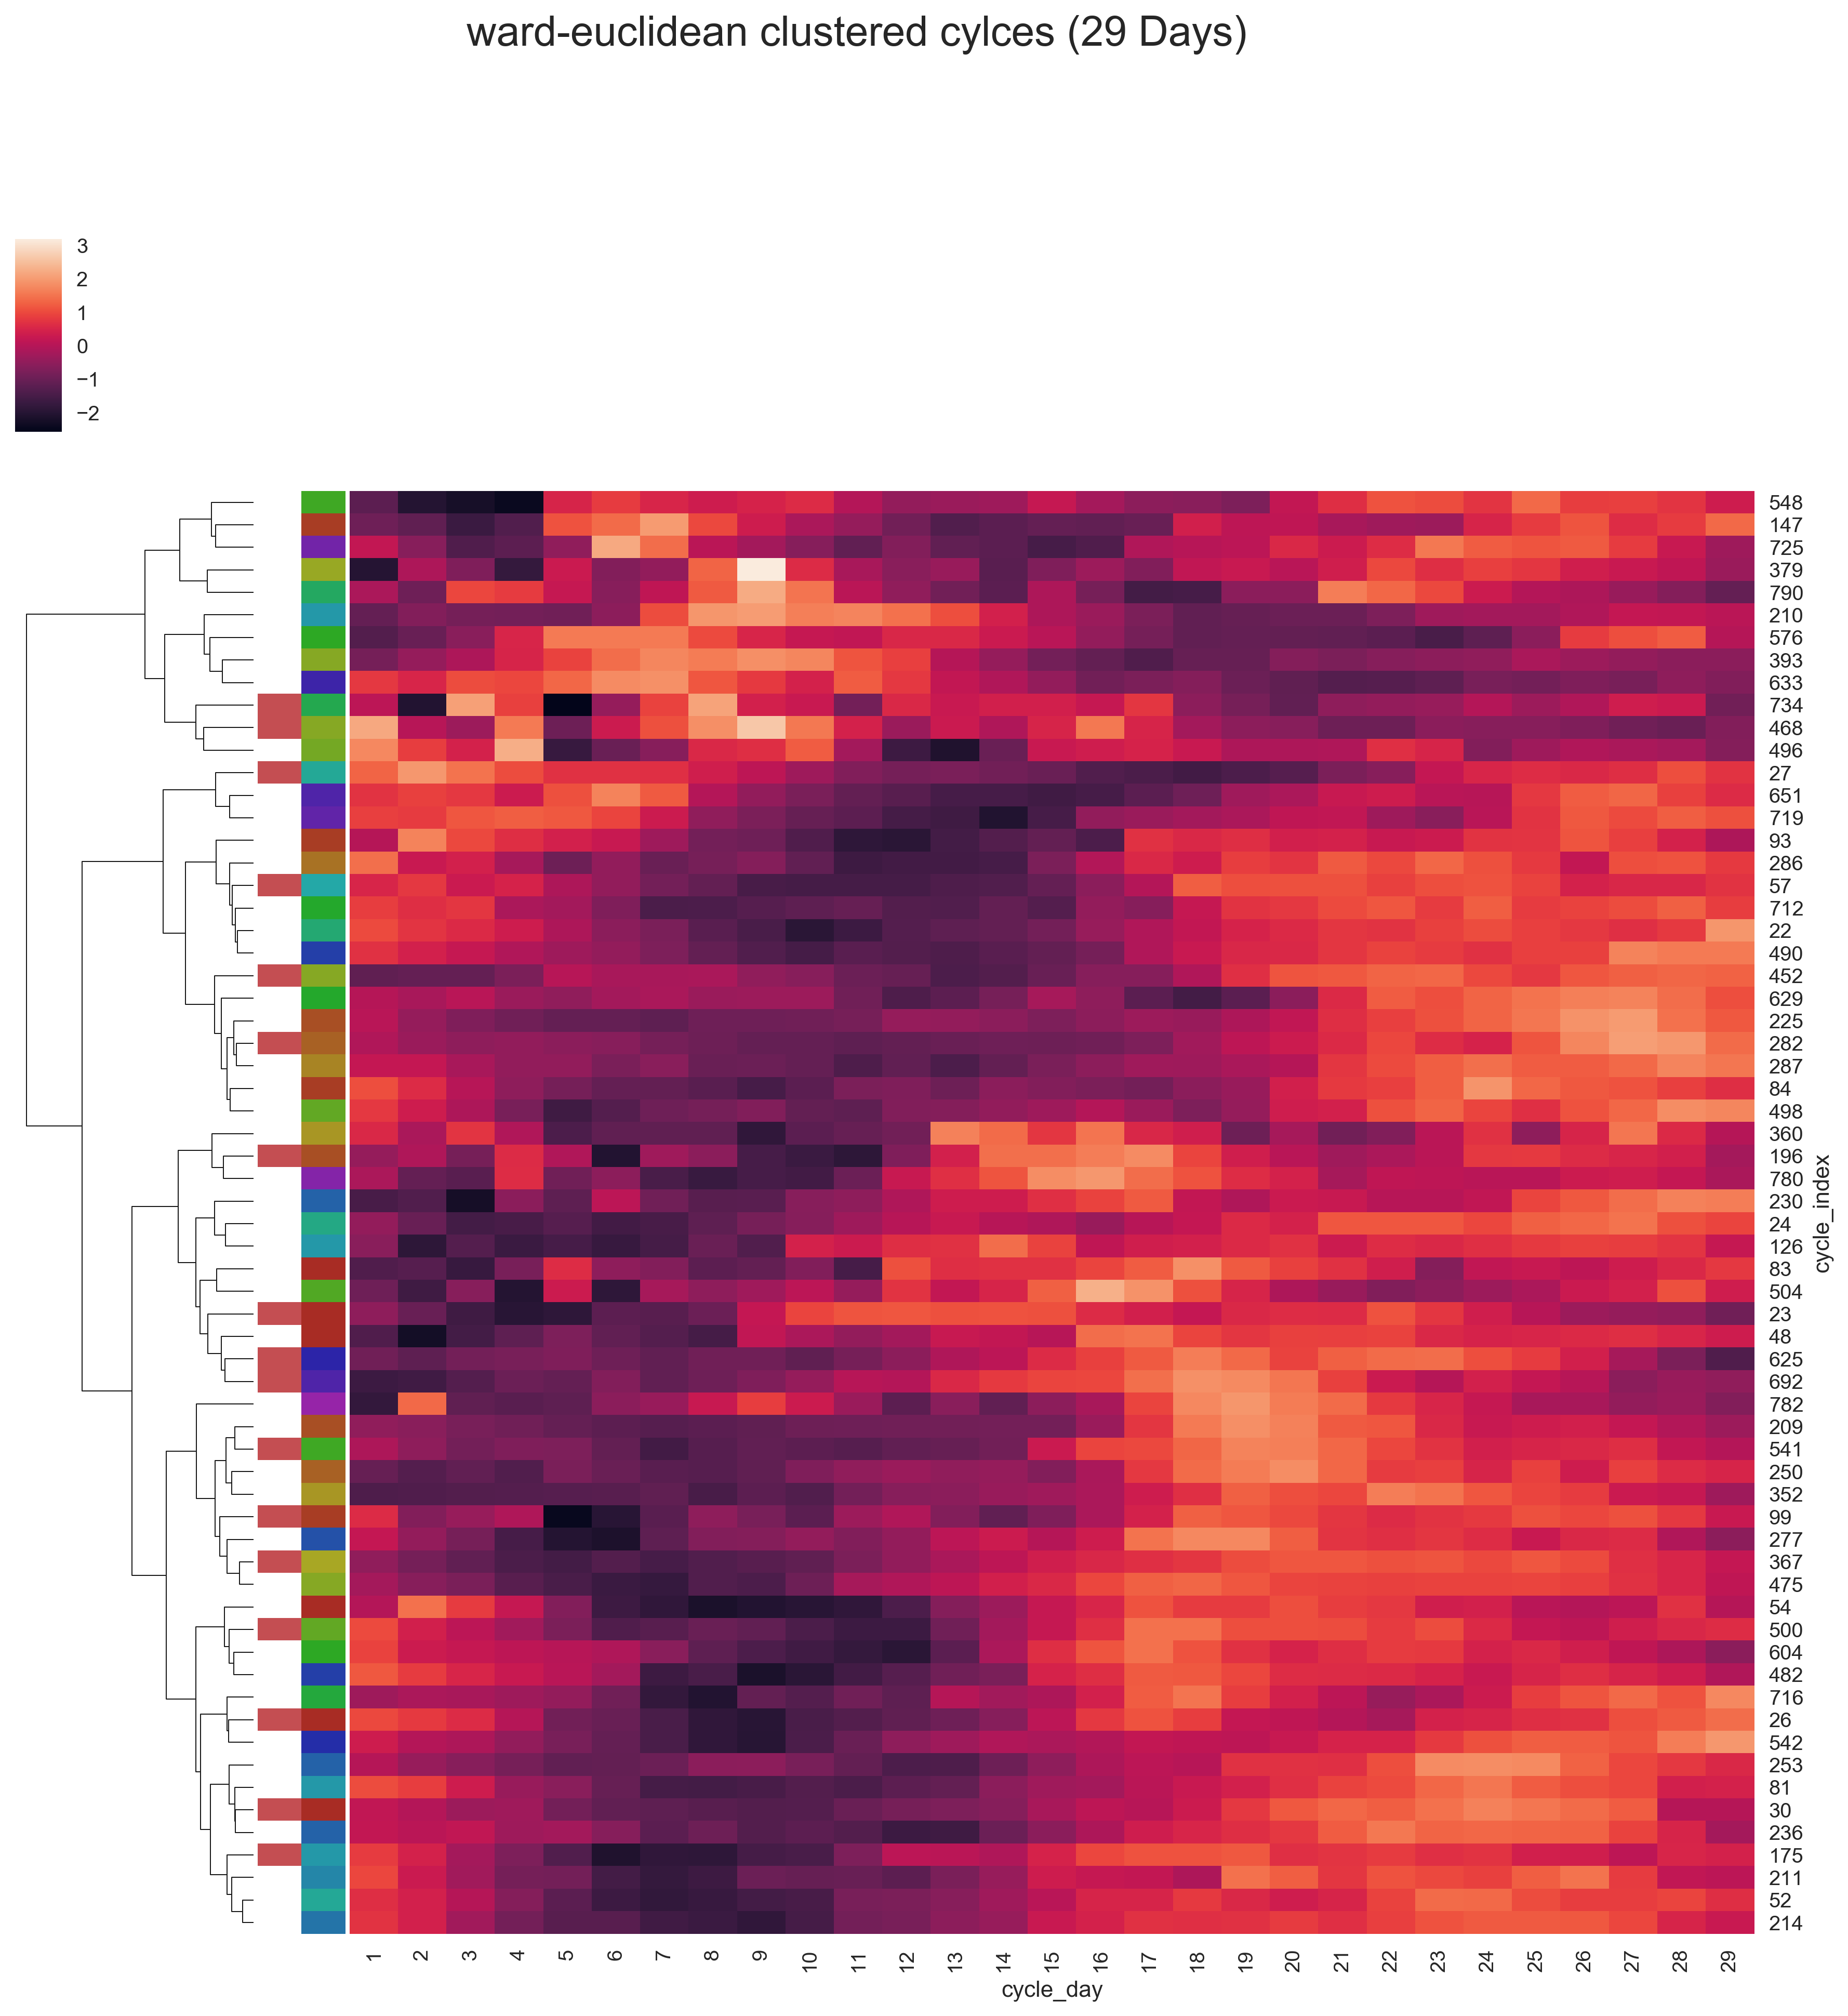

In [132]:
cycle_length = int(cycle_length)
print_heatmap2(timeSeries, user_cycle_df, cycle_length, metric, method, first_cycle = True)

plt.savefig('foo2.png', bbox_inches='tight')

In [78]:
#cycle_indeces cluster sorted
clustered_bray_complete = cluster_order(clusters, ts)

col [782, 496, 500, 504, 541, 780, 604, 24, 475, 52, 175, 214, 230, 277, 482, 625, 692, 126, 367, 23, 83, 196, 360, 209, 352, 99, 48, 54, 250, 210, 576, 633, 468, 393, 790, 734, 725, 379, 147, 548, 27, 719, 651, 452, 26, 287, 30, 542, 490, 498, 286, 22, 716, 282, 84, 211, 93, 225, 81, 57, 629, 712, 253, 236]
col_name hr
new cycle_index        782        496        500        504        541        780  \
cycle_day                                                                       
1            55.828966  68.016367  65.578319  54.133617  53.308239  60.017202   
2            63.696558  65.968926  64.259194  52.530090  52.061849  57.205243   
3            57.446332  65.018942  63.567571  54.921463  50.909954  56.727266   
4            57.184478  69.202372  62.755090  51.594832  51.441938  62.290065   
5            57.361214  60.055809  61.698401  57.074544  51.376249  57.648962   
6            58.893558  61.676475  60.332513  51.936159  50.228178  58.802390   
7            59.311485  62

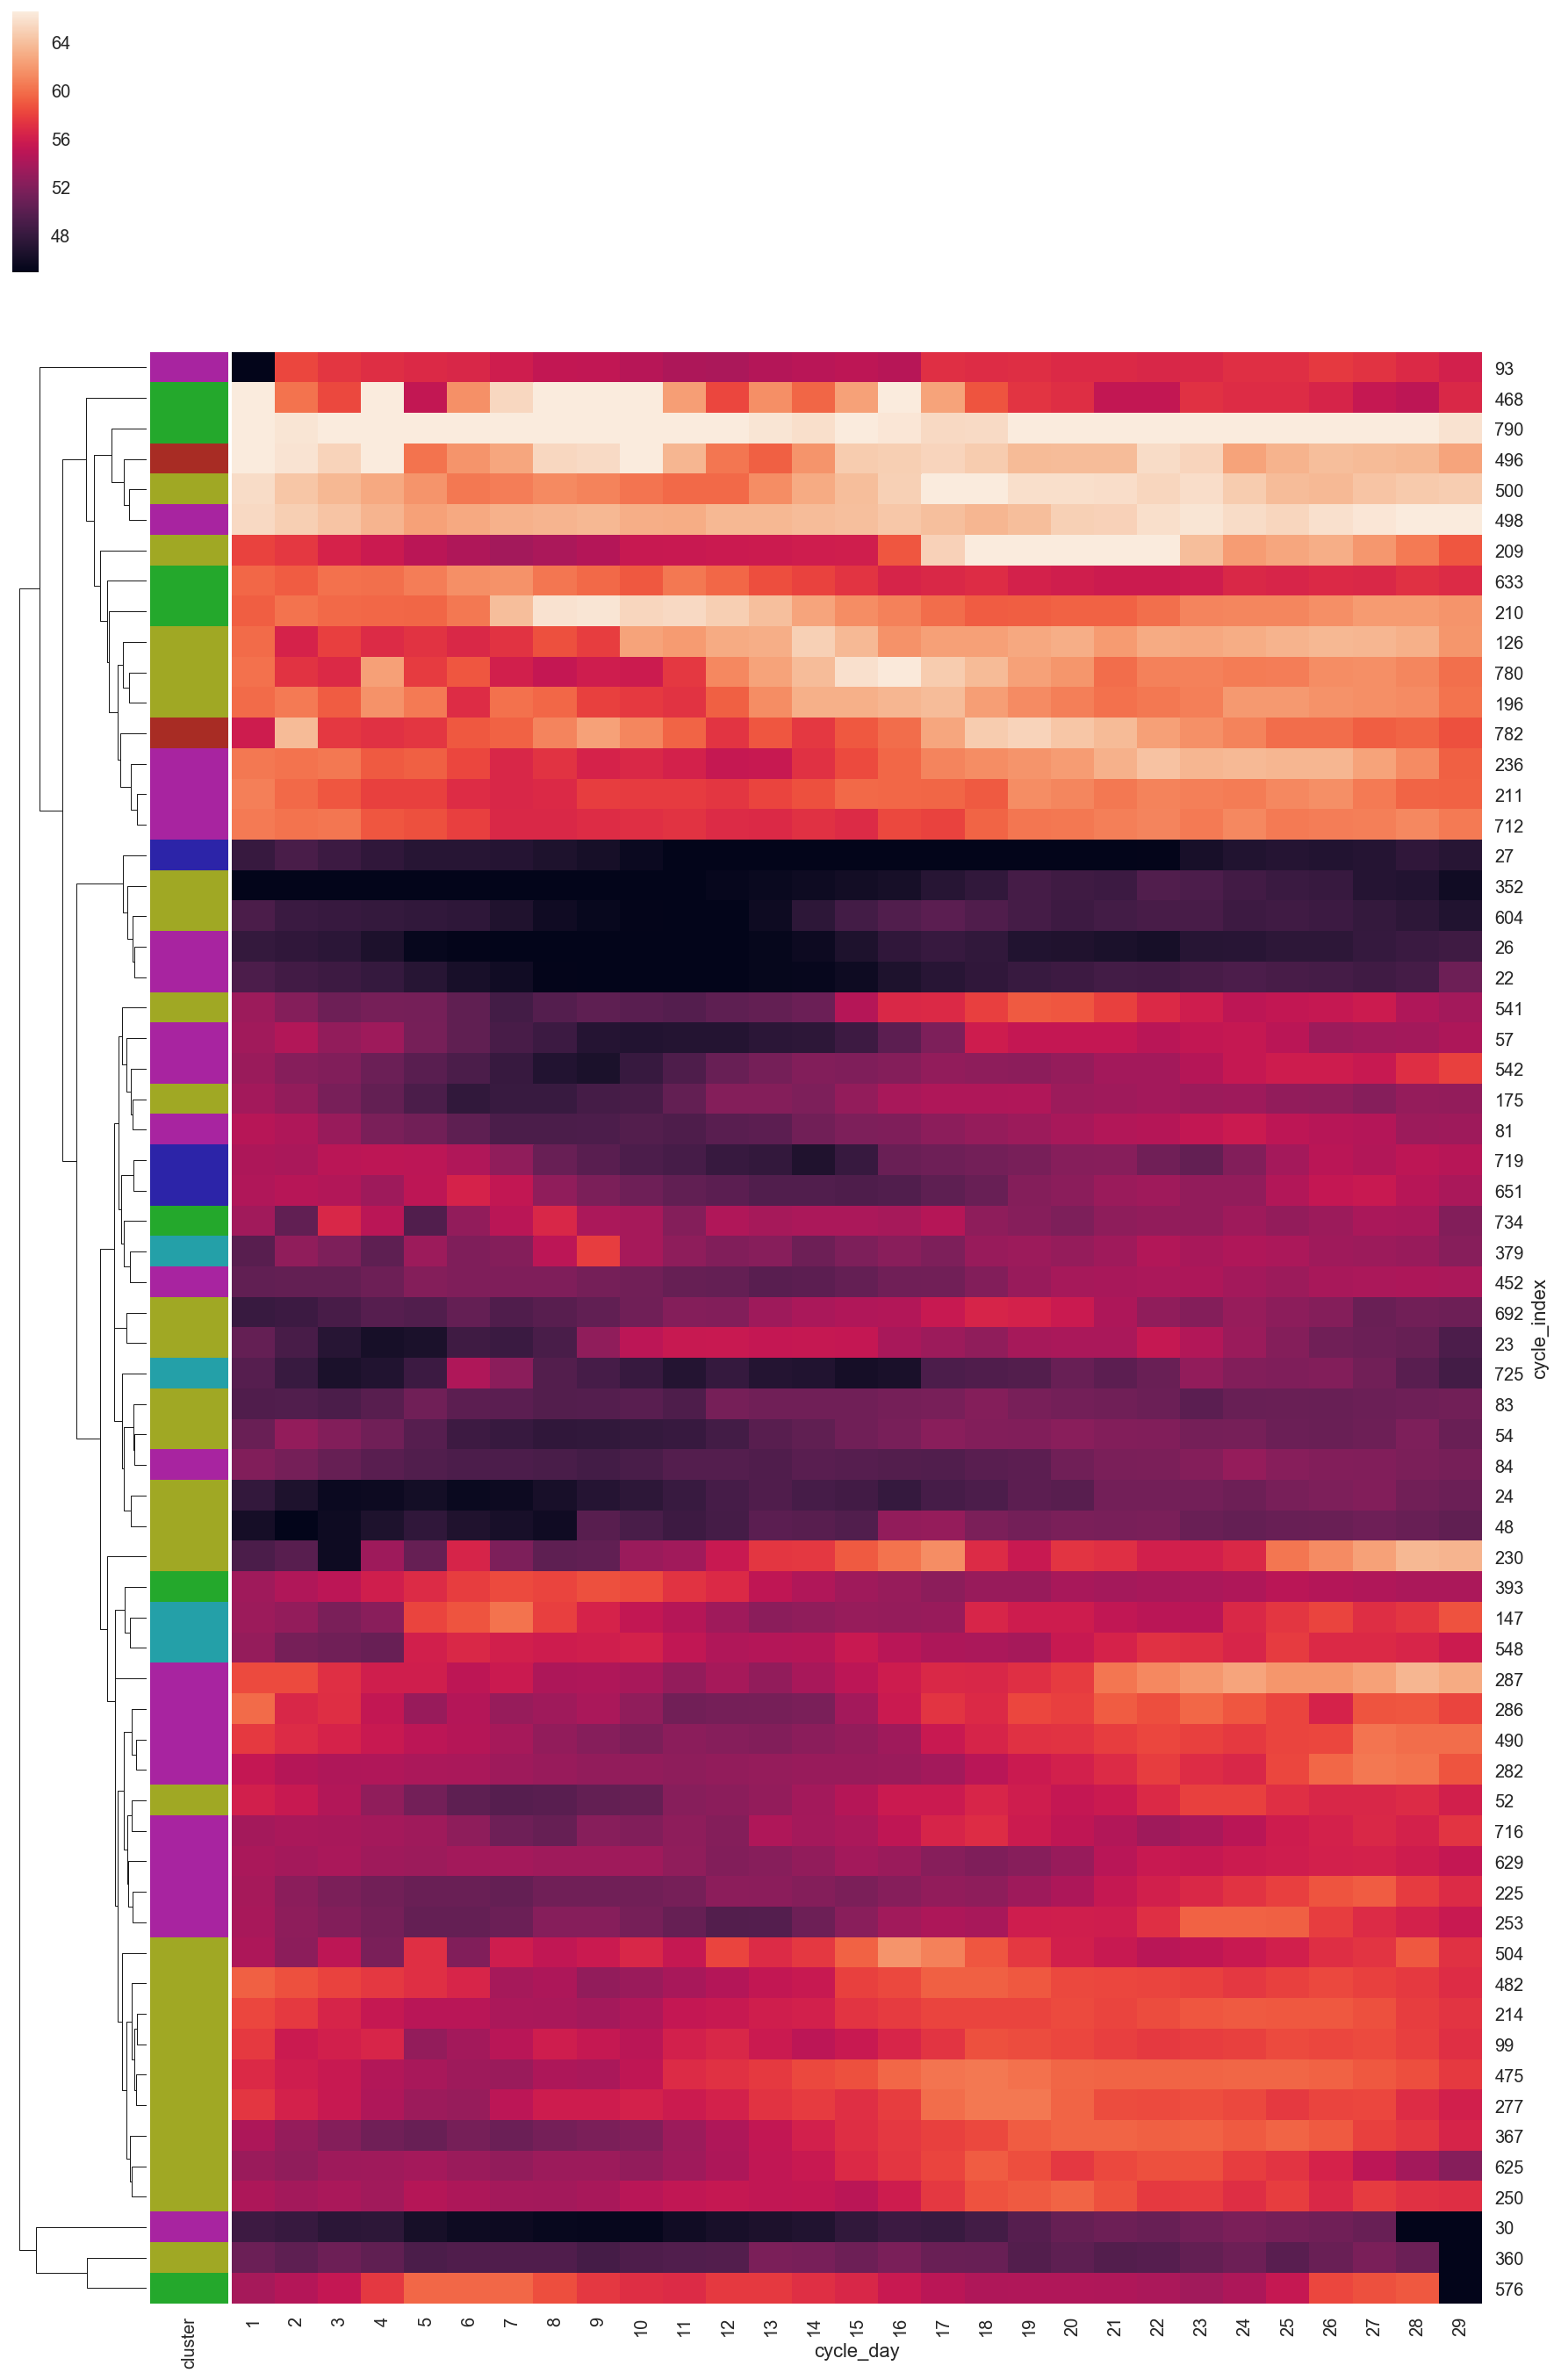

In [79]:
#heatmap of the original feature values sorted by clusters
heatmap_ordered(clustered_bray_complete, hr29_nan_md_cc)